# Conceptual building blocks

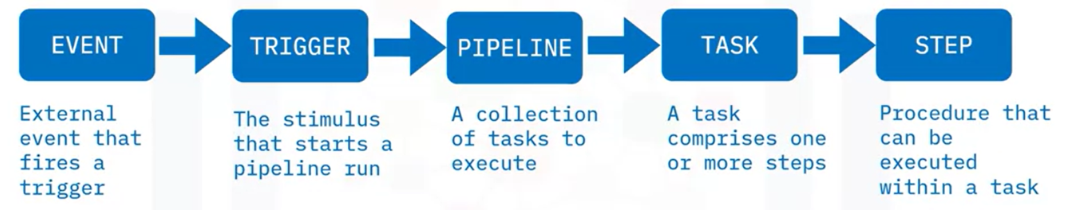

# Physical building blocks

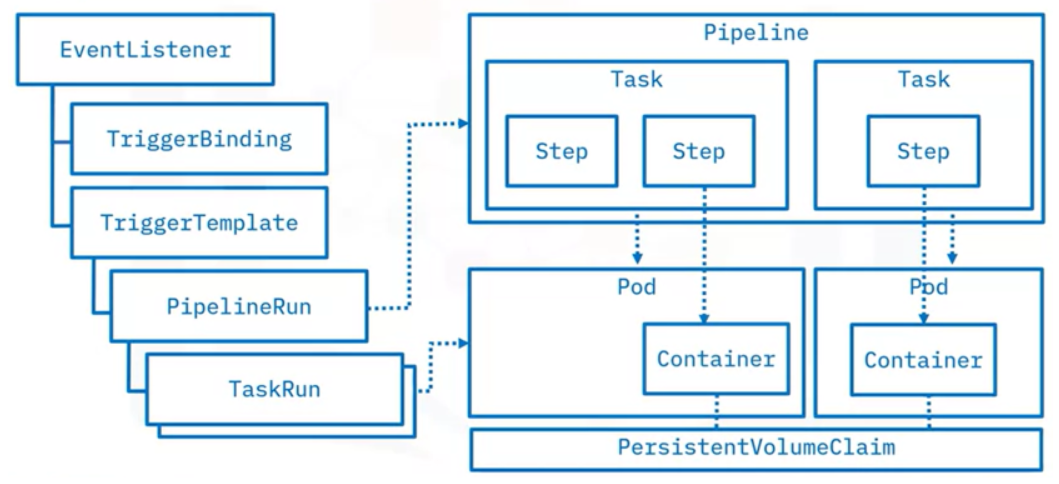

# High level Pipeline Design

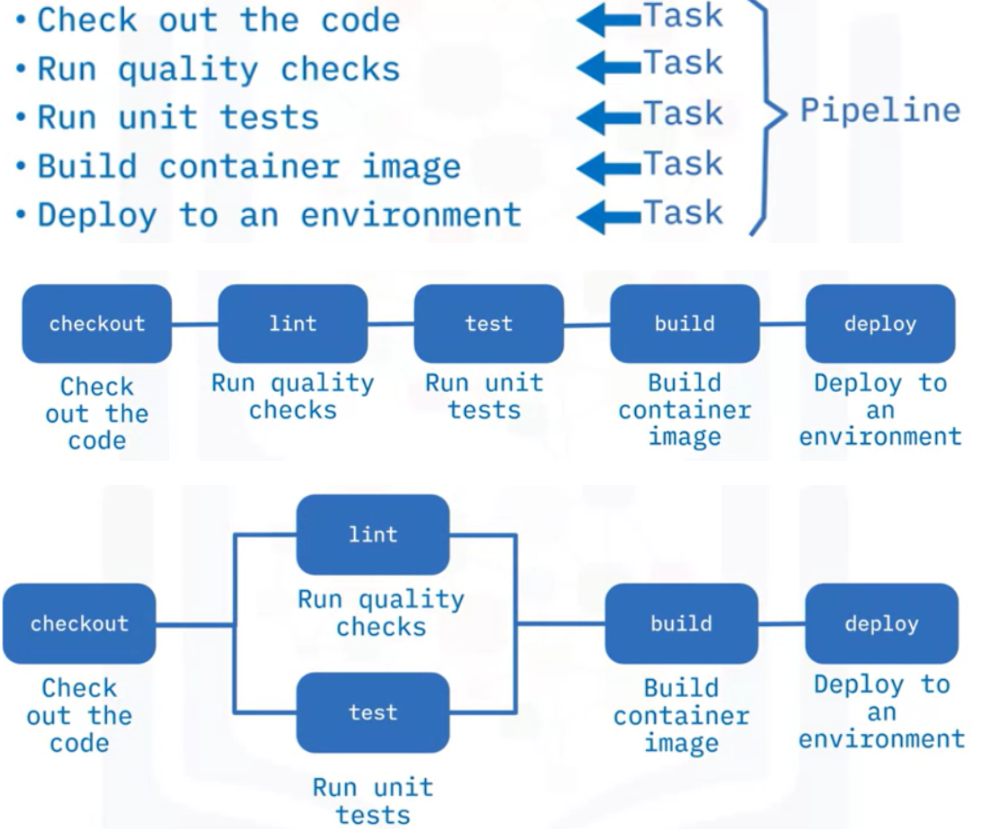

# `task.yaml`

```
apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: echo
spec:
  params:
    - name: message
      description: The message to echo
      type: string
  steps:
    - name: echo-message
      image: alpine:3
      command: [/bin/echo]
      args: ["$(params.message)"]

---

apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: checkout
spec:
  params:
    - name: repo-url
      description: The URL of the git repo to clone
      type: string
    - name: branch
      description: The branch to clone
      type: string
  steps:
    - name: checkout
      image: bitnami/git:latest
      command: [git]
      args: ["clone", "--branch", "$(params.branch)", "$(params.repo-url)"]
```

# `pipeline.yaml`

```
apiVersion: tekton.dev/v1beta1
kind: Pipeline
metadata:
  name: cd-pipeline
spec:
  params:
    - name: repo-url
    - name: branch
      default: "master"
  tasks:
    - name: clone
      taskRef:
        name: checkout
      params:
      - name: repo-url
        value: "$(params.repo-url)"
      - name: branch
        value: "$(params.branch)"

    - name: lint
      taskRef:
        name: echo
      params:
      - name: message
        value: "Calling Flake8 linter..."
      runAfter:
        - clone

    - name: tests
      taskRef:
        name: echo
      params:
      - name: message
        value: "Running unit tests with PyUnit..."
      runAfter:
        - lint

    - name: build
      taskRef:
        name: echo
      params:
      - name: message
        value: "Building image for $(params.repo-url) ..."
      runAfter:
        - tests

    - name: deploy
      taskRef:
        name: echo
      params:
      - name: message
        value: "Deploying $(params.branch) branch of $(params.repo-url) ..."
      runAfter:
        - build
```

# Run the pipeline

`kubectl apply -f tasks.yaml`

`kubectl apply -f pipeline.yaml`

`kubectl get pipelines`

**Finally, you’re ready to run your pipeline with the following command:**

```
tkn pipeline start cd-pipeline \
    --showlog \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch="main"
```

# EventListener: TriggerBinding & TriggerTemplate

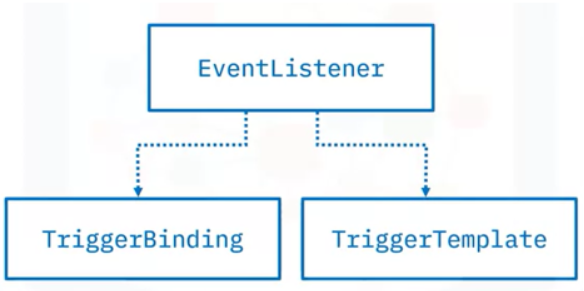

* The `TriggerBinding` CRD, which takes data from the event and binds it to the properties in your pipeline.
* The `TriggerTemplate` CRD, which takes data from the binding and instantiates a PipelineRun, passing in that data.

**Tekton triggers flow**

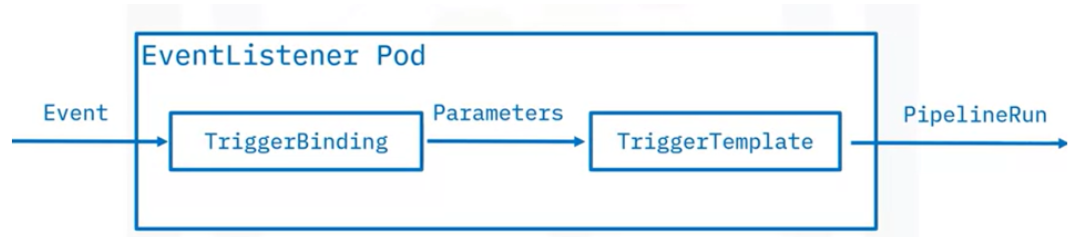

**Parameters flow**

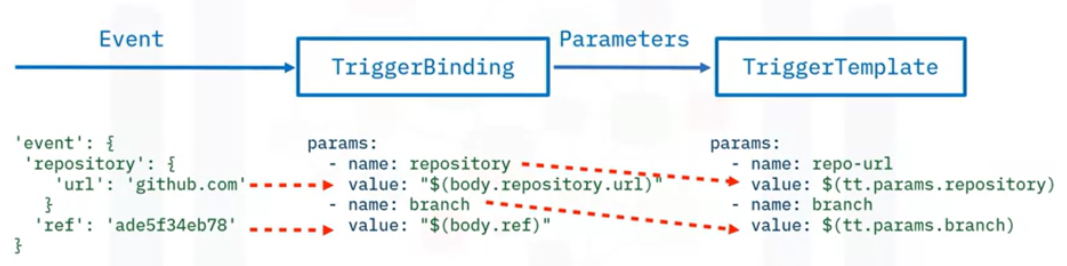

## `eventlistener.yaml`

```
apiVersion: triggers.tekton.dev/v1beta1
kind: EventListener
metadata:
  name: cd-listener
spec:
  serviceAccountName: pipeline
  triggers:
    - bindings:
      - ref: cd-binding
      template:
        ref: cd-template
```

**Apply the `EventListener` resource to the cluster:** `kubectl apply -f eventlistener.yaml`

**Check that it was created correctly:** `tkn eventlistener ls`

**You should see a reply similar to this:**

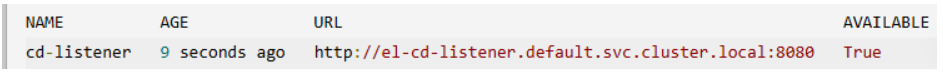

You will create the `TriggerBinding` named `cd-binding` and a `TriggerTemplate` named `cd-template` in the next steps.

## `triggerbinding.yaml`

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerBinding
metadata:
  name: cd-binding
spec:
  params:
    - name: repository
      value: $(body.repository.url)
    - name: branch
      value: $(body.ref)
```

**Apply the new `TriggerBinding` definition to the cluster:** `kubectl apply -f triggerbinding.yaml`

## `triggertemplate.yaml`

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerTemplate
metadata:
  name: cd-template
spec:
  params:
    - name: repository
      description: The git repo
      default: " "
    - name: branch
      description: the branch for the git repo
      default: master
  resourcetemplates:
    - apiVersion: tekton.dev/v1beta1
      kind: PipelineRun
      metadata:
        generateName: cd-pipeline-run-
      spec:
        serviceAccountName: pipeline
        pipelineRef:
          name: cd-pipeline
        params:
          - name: repo-url
            value: $(tt.params.repository)
          - name: branch
            value: $(tt.params.branch)
```

> *Note that while the parameter you bound from the event is `repository`, you pass it on as `repo-url` to the pipeline. This is to show that the names do not have to match, allowing you to use any pipeline to map parameters into.*

**Apply the new TriggerTemplate definition to the cluster:** `kubectl apply -f triggertemplate.yaml`

## Start a Pipeline Run

### Terminal 1: 

`Port Forwarding to expose a port for the eventListener to listen to external request`.

**Use the `kubectl port-forward` command to forward port `8090` to `8080`**.

```
kubectl port-forward service/el-cd-listener  8090:8080
```

**You will see the following output, but you will not get your cursor back.**

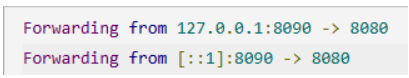

### Terminal 2: 

**Use the `curl` command to send a payload to the event listener service**

```
curl -X POST http://localhost:8090 \
  -H 'Content-Type: application/json' \
  -d '{"ref":"main","repository":{"url":"https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode"}}'
```

**This should start a `PipelineRun`.** 

**You can check on the status with this command:** `tkn pipelinerun ls`

**You should see something like this come back:**

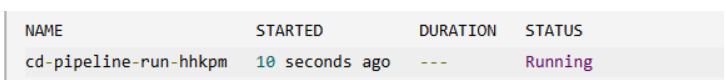

You can also examine the `PipelineRun` logs using this command (the `-L` means **"latest"** so that you do not have to look up the name for the last run): 

```
tkn pipelinerun logs --last
```

**You should see:**

```
[clone : checkout] Cloning into 'wtecc-CICD_PracticeCode'...

[lint : echo-message] Calling Flake8 linter...

[tests : echo-message] Running unit tests with PyUnit...

[build : echo-message] Building image for https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode ...

[deploy : echo-message] Deploying master branch of https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode ...
```

# Install `git-clone` tekton task

Use this command to install the `git-clone` task from **Tekton Hub** (`hub.tekton.dev`):
```
tkn hub install task git-clone --version 0.8
```

# Workspace

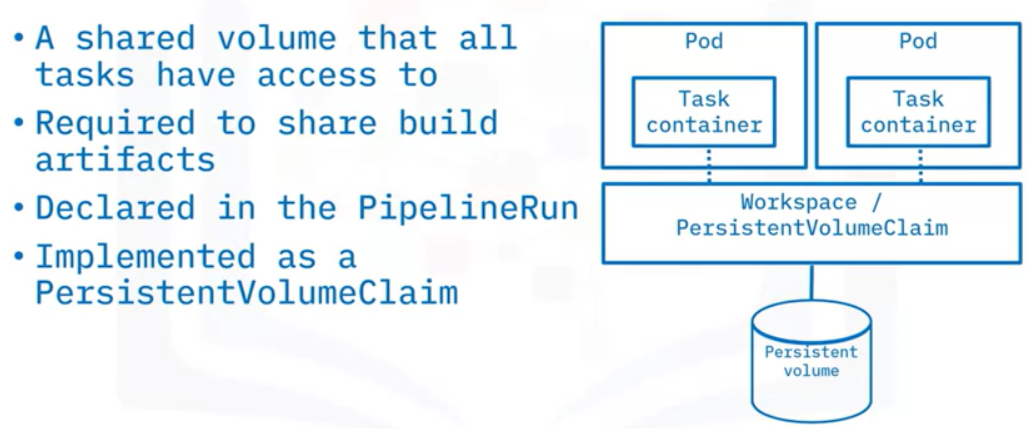

## Create a Workspace: `pvc.yaml`

```
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: pipelinerun-pvc
spec:
  storageClassName: skills-network-learner
  resources:
    requests:
      storage:  1Gi
  volumeMode: Filesystem
  accessModes:
    - ReadWriteOnce
```

**Apply the new task definition to the cluster:**

```
kubectl apply -f pvc.yaml
```

**You should see the following output:**

```
persistentvolumeclaim/pipelinerun-pvc created
```

You can now reference this persistent volume by its name `pipelinerun-pvc` when creating workspaces for your Tekton tasks.

Next, update `PipelineRun` defined in `triggertemplate.yaml` 

## `triggertemplate.yaml`

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerTemplate
metadata:
  name: cd-template
spec:
  params:
    - name: repository
      description: The git repo
      default: " "
    - name: branch
      description: the branch for the git repo
      default: master
  resourcetemplates:
    - apiVersion: tekton.dev/v1beta1
      kind: PipelineRun
      metadata:
        generateName: cd-pipeline-run-
      spec:
        serviceAccountName: pipeline
        pipelineRef:
          name: cd-pipeline
        workspace:
          - name: pipleline-workspace
            persistentVolumeClaim:
                claimName: pipelinerun-pvc
        params:
          - name: repo-url
            value: $(tt.params.repository)
          - name: branch
            value: $(tt.params.branch)
```

**Apply the new TriggerTemplate definition to the cluster:** `kubectl apply -f triggertemplate.yaml`

## Add a Workspace to the Pipeline: `pipeline.yaml`

```
apiVersion: tekton.dev/v1beta1
kind: Pipeline
metadata:
  name: cd-pipeline
spec:
  workspaces:
    - name: pipeline-workspace
  params:
    - name: repo-url
    - name: branch
      default: "master"
  tasks:
    - name: clone
      workspaces:
        - name: output
          workspace: pipeline-workspace
      taskRef:
        name: git-clone
      params:
      - name: url
        value: $(params.repo-url)
      - name: revision
        value: $(params.branch)

    - name: lint
      taskRef:
        name: echo
      params:
      - name: message
        value: "Calling Flake8 linter..."
      runAfter:
        - clone

    - name: tests
      taskRef:
        name: echo
      params:
      - name: message
        value: "Running unit tests with PyUnit..."
      runAfter:
        - lint

    - name: build
      taskRef:
        name: echo
      params:
      - name: message
        value: "Building image for $(params.repo-url) ..."
      runAfter:
        - tests

    - name: deploy
      taskRef:
        name: echo
      params:
      - name: message
        value: "Deploying $(params.branch) branch of $(params.repo-url) ..."
      runAfter:
        - build
```

**Apply the pipeline to your cluster:**

```
kubectl apply -f pipeline.yaml
```

**You should see output similar to this:**

```
$ kubectl apply -f pipeline.yaml
pipeline.tekton.dev/cd-pipeline created
```

> **Note:** *If the original pipeline was already created, you will see the word “configured” instead of “created.”*

You are now ready to run your pipeline.

## Run the Pipeline

You can now use the **Tekton CLI (`tkn`)** to create a `PipelineRun` to run the pipeline.

Use the following command to run the pipeline, passing in:
* the URL of the repository,
* the branch to clone,
* the workspace name, and
* the persistent volume claim name.

```
tkn pipeline start cd-pipeline \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch="main" \
    -w name=pipeline-workspace,claimName=pipelinerun-pvc \
    --showlog
```

**You should see output similar to this:**

```
PipelineRun started: cd-pipeline-run-mndgw
Waiting for logs to be available...

[clone : clone] <- There will be many lines from git-clone
[clone : clone] ...
[lint : echo-message] Calling Flake8 linter...
[tests : echo-message] Running unit tests with PyUnit...
[build : echo-message] Building image for https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git ...
[deploy : echo-message] Deploying main branch of https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git ...
```

**You can always see the pipeline run status by listing the `PipelineRuns` with:**
```
tkn pipelinerun ls
```

**You should see:**

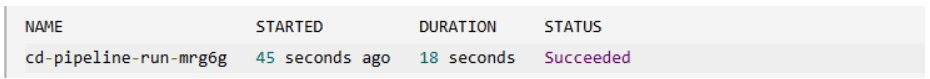

**You can check the logs of the last run with:**

```
tkn pipelinerun logs --last
```

# Using environment properties: `Secret` credentials

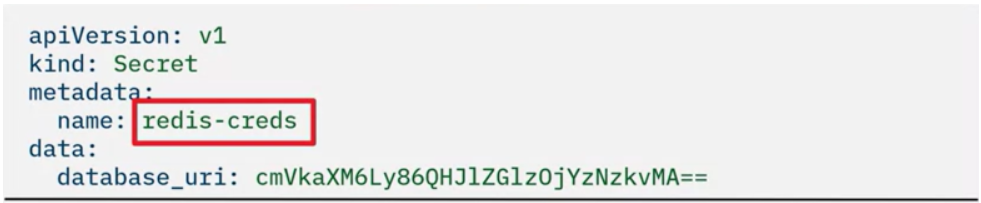

# Create tasks for quality checks

## Install `flake8` tekton task

You are going to use `flake8` to `lint` your code. Luckily, Tekton Hub has a flake8 task that you can install and use:

Use the following **Tekton CLI** command to install the `flake8` task into your namespace.
```
tkn hub install task flake8
```

This will install the `flake8` task in your Kubernetes namespace.

You should see output similar to this:
```
Task flake8(0.1) installed in sn-labs-rofrano namespace
```

## Modify the pipeline to use `flask8` for `lint` task

```
    - name: lint
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: flake8
      params:
      - name: image
        value: "python:3.9-slim"
      - name: args
        value: ["--count","--max-complexity=10","--max-line-length=127","--statistics"]
      runAfter:
        - clone

    # Note: The remaining tasks are unchanged
```

**Apply these changes to your cluster:** `kubectl apply -f pipeline.yaml`

You should see the following output:
```
pipeline.tekton.dev/cd-pipeline configured
```

## Create a `tests` task for running `nosetests`: `tasks.yaml`

```
---
apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: nose
spec:
  workspaces:
    - name: source
      workspace: pipeline-workspace
  params:
    - name: args
      description: Arguments to pass to nose
      type: string
      default: "-v"
  steps:
    - name: nosetests
      image: python:3.9-slim
      workingDir: $(workspaces.source.path)
      script: |
        #!/bin/bash
        set -e
        python -m pip install --upgrade pip wheel
        pip install -r requirements.txt
        nosetests $(params.args)
```

**Apply these changes to your cluster:** `kubectl apply -f tasks.yaml`

**You should see the following output:**
```
task.tekton.dev/echo configured
task.tekton.dev/cleanup configured
task.tekton.dev/nose created
```

## Modify the pipeline to use `nosetests` for `tests` task

```
    - name: tests
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: nose
      params:
      - name: args
        value: "-v --with-spec --spec-color"
      runAfter:
        - lint
```

**Apply these changes to your cluster:** `kubectl apply -f pipeline.yaml`

**You should see the following output:**
```
pipeline.tekton.dev/cd-pipeline configured
```

## Run the Pipeline

Now that you have your `lint` and `tests` task complete, run the pipeline again using the Tekton CLI to see your new test tasks run:
```
tkn pipeline start cd-pipeline \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch="main" \
    -w name=pipeline-workspace,claimName=pipelinerun-pvc \
    --showlog
```

**You can see the pipeline run status by listing the `PipelineRun` with:** `tkn pipelinerun ls`

**You should see:**

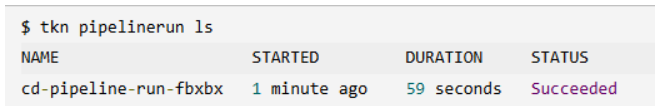

**You can check the logs of the last run with:** `tkn pipelinerun logs --last`
